<h4>
    
`events_train.csv` - данные о действиях, которые совершают студенты со стэпами
</h4>
<h4>
    
    1.step_id - id стэпа
    2.user_id - анонимизированный id юзера
    3.timestamp - время наступления события в формате unix date
    4.action - событие, возможные значения: 

    -discovered - пользователь перешел на стэп
    -viewed - просмотр шага,
    -started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
    -passed - удачное решение практического шага
    
</h4>
<h4>
    
`submissions_train.csv` - данные о времени и статусах сабмитов к практическим заданиям
</h4>
<h4>
    
    1.step_id - id стэпа
    2.timestamp - время отправки решения в формате unix date
    3.submission_status - статус решения
    4.user_id - анонимизированный id юзера
</h4>

In [95]:
from sklearn import tree
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score

<h2>Предобработка тренировочного датасета</h2>

In [145]:
events_train = pd.read_csv('event_data_train_R.csv')
submission_train = pd.read_csv('submissions_data_train_R.csv')

In [3]:
events_train.isnull().sum()#Проверяем на отсутствие данных

step_id      0
timestamp    0
action       0
user_id      0
dtype: int64

In [10]:
submission_train.isnull().sum()#Проверяем на отсутствие данных

step_id              0
timestamp            0
submission_status    0
user_id              0
date                 0
day                  0
dtype: int64

In [11]:
events_train['date'] = pd.to_datetime(events_train.timestamp, unit='s') 
submission_train['date'] = pd.to_datetime(events_train.timestamp, unit='s')
#Переводим время в более удобно читаемый вариант(s - означает секунда)

In [12]:
events_train.date.max()
events_train.date.min()

Timestamp('2015-06-15 04:00:48')

In [13]:
events_train['day'] = events_train.date.dt.date # Добавялем сет с днями 
submission_train['day'] = submission_train.date.dt.date

<h4>Создаем таблицу с последним действием юзера</h4>

In [14]:
min_max_user_time = events_train.groupby('user_id').agg({'timestamp': 'min'}) \
                            .rename(columns={'timestamp': 'min_timestamp'}) \
                            .reset_index()

In [15]:
min_max_user_time.head()# Берем минимальный timestamp для каждого юзера

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [16]:
learning_time_threshold = 2 * 24 * 60 * 60 #два дня в секундах

In [17]:
events_2d = pd.merge(events_train, min_max_user_time, on='user_id', how='outer')

In [146]:
events_2d = events_2d.query('timestamp <= min_timestamp + @learning_time_threshold')
#отбираем те записи, которые не позднее двух дней

In [19]:
events_2d.user_id.nunique()#Проверка на потерю данных

19234

In [20]:
events_2d.head()

,step_id,timestamp,action,user_id,date,day,min_timestamp
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848


In [21]:
min_max_user_time = submission_train.groupby('user_id').agg({'timestamp': 'min'}) \
                            .rename(columns={'timestamp': 'min_timestamp'}) \
                            .reset_index()

In [22]:
submission_2d = pd.merge(submission_train, min_max_user_time, on='user_id', how='outer')

In [23]:
submission_2d = submission_2d.query('timestamp <= min_timestamp + @learning_time_threshold')
#отбираем те записи, которые не позднее двух дней с начала учебы

In [24]:
users_events_data = events_2d.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count',
                      fill_value=0).reset_index()
#таблица со всеми действиями юзеров

In [25]:
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,9
2,3,15,15,4,20
3,5,1,1,0,1
4,7,1,1,0,1


In [26]:
users_scores = submission_2d.pivot_table(
    index='user_id', columns='submission_status', values='step_id',
    aggfunc='count', fill_value=0
).reset_index()
#таблица с колво правильных и неправильных попыток

In [27]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,4,4
2,5,2,2
3,8,9,21
4,14,0,1


In [28]:
users_data = pd.merge(users_events_data, users_scores, on='user_id', how='outer')

In [29]:
users_data = users_data.fillna(0)

In [30]:
users_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong
0,1,1,0,0,1,0.0,0.0
1,2,9,9,2,9,2.0,0.0
2,3,15,15,4,20,4.0,4.0
3,5,1,1,0,1,2.0,2.0
4,7,1,1,0,1,0.0,0.0


In [31]:
users_data.user_id.nunique()

19234

<h4>Считаем кол-во решенных задач. В конце создаем новую таблицу, если юзер решил больше 40 задач, то предсказываем, что он закончит курс</h4>

In [32]:
users_count_correct = submission_train[submission_train.submission_status == 'correct'] \
                .groupby('user_id').agg({'step_id': 'count'}) \
                .reset_index().rename(columns={'step_id': 'corrects'})

In [33]:
threshold = 40

In [34]:
users_count_correct['passed_course'] = (users_count_correct.corrects >= threshold).astype('int')

In [35]:
users_count_correct.head()

,user_id,corrects,passed_course
0,2,2,0
1,3,29,0
2,5,2,0
3,8,9,0
4,16,77,1


<h4>Время потраченное на курс(добавляем отдельно в днях)</h4>

In [36]:
users_time_feature = events_2d.groupby('user_id').agg({'timestamp': ['min', 'max'], 'day': 'nunique'}) \
                        .droplevel(level=0, axis=1) \
                        .rename(columns={'nunique': 'days'}) \
                        .reset_index()

In [37]:
users_time_feature.head(10)

,user_id,min,max,days
0,1,1472827464,1472827464,1
1,2,1514383364,1514383555,1
2,3,1434358476,1434359582,1
3,5,1466156809,1466156809,1
4,7,1521634660,1521634660,1
5,8,1480603427,1480604155,1
6,9,1484999434,1484999497,1
7,11,1526140624,1526140625,1
8,14,1436366155,1436368676,1
9,16,1435674765,1435760929,2


In [38]:
users_time_feature['hours'] = round((users_time_feature['max'] - users_time_feature['min']) / 3600, 1)

In [39]:
users_time_feature.head(10)

,user_id,min,max,days,hours
0,1,1472827464,1472827464,1,0.0
1,2,1514383364,1514383555,1,0.1
2,3,1434358476,1434359582,1,0.3
3,5,1466156809,1466156809,1,0.0
4,7,1521634660,1521634660,1,0.0
5,8,1480603427,1480604155,1,0.2
6,9,1484999434,1484999497,1,0.0
7,11,1526140624,1526140625,1,0.0
8,14,1436366155,1436368676,1,0.7
9,16,1435674765,1435760929,2,23.9


In [40]:
users_time_feature = users_time_feature.drop(['max', 'min'], axis=1)

In [41]:
users_time_feature.head()

,user_id,days,hours
0,1,1,0.0
1,2,1,0.1
2,3,1,0.3
3,5,1,0.0
4,7,1,0.0


<h4>Попытки пользователей</h4>

In [42]:
steps_tried = submission_2d.groupby('user_id').step_id.nunique().to_frame().reset_index() \
                                        .rename(columns={'step_id': 'steps_tried'})

In [43]:
steps_tried.head()

,user_id,steps_tried
0,2,2
1,3,4
2,5,2
3,8,11
4,14,1


In [44]:
#Создание фичи с долей правильных ответов

In [45]:
users_data['correct_ratio'] = (users_data.correct / (users_data.correct + users_data.wrong)).fillna(0)

In [46]:
users_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,correct_ratio
0,1,1,0,0,1,0.0,0.0,0.0
1,2,9,9,2,9,2.0,0.0,1.0
2,3,15,15,4,20,4.0,4.0,0.5
3,5,1,1,0,1,2.0,2.0,0.5
4,7,1,1,0,1,0.0,0.0,0.0


<h4>Объединяю все фреймы</h4>

In [47]:
pre_total_data = pd.merge(users_data, steps_tried, how='outer')

In [48]:
pre_total_data = pre_total_data.fillna(0)

In [49]:
pre_total_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,correct_ratio,steps_tried
0,1,1,0,0,1,0.0,0.0,0.0,0.0
1,2,9,9,2,9,2.0,0.0,1.0,2.0
2,3,15,15,4,20,4.0,4.0,0.5,4.0
3,5,1,1,0,1,2.0,2.0,0.5,2.0
4,7,1,1,0,1,0.0,0.0,0.0,0.0


In [50]:
pre_total_data = pd.merge(pre_total_data, users_time_feature, how='outer')

In [51]:
total_data = pd.merge(pre_total_data, users_count_correct, how='outer')

In [52]:
total_data = total_data.fillna(0)

In [53]:
total_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,correct_ratio,steps_tried,days,hours,corrects,passed_course
0,1,1,0,0,1,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0
1,2,9,9,2,9,2.0,0.0,1.0,2.0,1,0.1,2.0,0.0
2,3,15,15,4,20,4.0,4.0,0.5,4.0,1,0.3,29.0,0.0
3,5,1,1,0,1,2.0,2.0,0.5,2.0,1,0.0,2.0,0.0
4,7,1,1,0,1,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0


<h2>Предобработка тестового датасета</h2>

In [54]:
events_test = pd.read_csv('events_data_test_R.csv')
submission_test = pd.read_csv('submission_data_test_R.csv')

In [55]:
events_test.user_id.nunique()

6184

In [56]:
events_test['date'] = pd.to_datetime(events_test.timestamp, unit='s')
events_test['day'] = events_test['date'].dt.date

In [57]:
min_max_user_time = events_test.groupby('user_id').agg({'timestamp': 'min'}) \
                            .rename(columns={'timestamp': 'min_timestamp'}) \
                            .reset_index()
    
events_2d_test = pd.merge(events_test, min_max_user_time, on='user_id', how='outer')
    
    # отбираем те записи, которые не позднее двух дней с начала учебы
learning_time_threshold = 2 * 24 * 60 * 60
events_2d_test = events_2d_test.query("timestamp <= min_timestamp + @learning_time_threshold")

In [58]:
min_max_user_time = submission_test.groupby('user_id').agg({'timestamp': 'min'}) \
                            .rename(columns={'timestamp': 'min_timestamp'}) \
                            .reset_index()

In [59]:
submission_2d_test = pd.merge(submission_test, min_max_user_time, on='user_id', how='outer')

In [60]:
submission_2d_test = submission_2d_test.query('timestamp <= min_timestamp + @learning_time_threshold')
#отбираем те записи, которые не позднее двух дней с начала учебы

In [61]:
users_events_data_test = events_2d_test.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count',
                      fill_value=0).reset_index()
#таблица со всеми действиями юзеров

In [62]:
users_events_data_test.head()

action,user_id,discovered,passed,started_attempt,viewed
0,4,1,1,0,1
1,6,1,1,0,1
2,10,2,2,0,6
3,12,11,9,4,14
4,13,70,70,35,105


In [63]:
users_scores_test = submission_2d_test.pivot_table(
    index='user_id', columns='submission_status', values='step_id',
    aggfunc='count', fill_value=0
).reset_index()
#таблица с колво правильных и неправильных попыток

In [64]:
users_scores_test.head()

submission_status,user_id,correct,wrong
0,12,1,0
1,13,29,36
2,15,10,30
3,21,24,103
4,35,7,35


In [65]:
users_data_test = pd.merge(users_events_data_test, users_scores_test, on='user_id', how='outer')

In [66]:
users_data_test = users_data_test.fillna(0)

In [67]:
users_data_test.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong
0,4,1,1,0,1,0.0,0.0
1,6,1,1,0,1,0.0,0.0
2,10,2,2,0,6,0.0,0.0
3,12,11,9,4,14,1.0,0.0
4,13,70,70,35,105,29.0,36.0


In [68]:
events_2d_test.head()

,step_id,timestamp,action,user_id,date,day,min_timestamp
0,30456,1526893787,viewed,24417,2018-05-21 09:09:47,2018-05-21,1526893439
1,30456,1526893797,viewed,24417,2018-05-21 09:09:57,2018-05-21,1526893439
2,30456,1526893954,viewed,24417,2018-05-21 09:12:34,2018-05-21,1526893439
3,30456,1526895780,viewed,24417,2018-05-21 09:43:00,2018-05-21,1526893439
4,30456,1526893787,discovered,24417,2018-05-21 09:09:47,2018-05-21,1526893439


In [69]:
users_time_feature_test = events_2d_test.groupby('user_id').agg({'timestamp': ['min', 'max'], 'day': 'nunique'}) \
                        .droplevel(level=0, axis=1) \
                        .rename(columns={'nunique': 'days'}) \
                        .reset_index()

In [70]:
users_time_feature_test['hours'] = round((users_time_feature_test['max'] - users_time_feature_test['min']) / 3600, 1)
    

In [71]:
users_time_feature_test = users_time_feature_test.drop(['min', 'max'], axis=1)

In [72]:
users_time_feature_test.head()

,user_id,days,hours
0,4,1,0.0
1,6,1,0.0
2,10,1,2.2
3,12,1,0.0
4,13,2,35.5


In [73]:
steps_tried_test = submission_test.groupby('user_id').step_id.nunique().to_frame().reset_index() \
                                        .rename(columns={'step_id': 'steps_tried'})
    

In [74]:
users_data_test['correct_ratio'] = (users_data_test.correct / (users_data_test.correct + users_data_test.wrong)).fillna(0)

In [75]:
users_data_test.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,correct_ratio
0,4,1,1,0,1,0.0,0.0,0.000000
1,6,1,1,0,1,0.0,0.0,0.000000
2,10,2,2,0,6,0.0,0.0,0.000000
3,12,11,9,4,14,1.0,0.0,1.000000
4,13,70,70,35,105,29.0,36.0,0.446154


In [76]:
total_test = pd.merge(users_data_test, steps_tried_test, how='outer').fillna(0)

In [77]:
total_test.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,correct_ratio,steps_tried
0,4,1,1,0,1,0.0,0.0,0.000000,0.0
1,6,1,1,0,1,0.0,0.0,0.000000,0.0
2,10,2,2,0,6,0.0,0.0,0.000000,0.0
3,12,11,9,4,14,1.0,0.0,1.000000,1.0
4,13,70,70,35,105,29.0,36.0,0.446154,29.0


In [78]:
total_test = pd.merge(total_test, users_time_feature_test, how='outer')

In [79]:
total_test.isnull().sum()

user_id            0
discovered         0
passed             0
started_attempt    0
viewed             0
correct            0
wrong              0
correct_ratio      0
steps_tried        0
days               0
hours              0
dtype: int64

In [80]:
total_test.user_id.nunique()

6184

<h2>Ищем лучшие параметры для обучения</h2>

In [115]:
X_train = total_data.drop(['passed_course', 'corrects'], axis=1)
y_train = total_data['passed_course'].map(int)
X_test = total_test

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

In [117]:
clf_rf = RandomForestClassifier()

In [118]:
parametrs = {'n_estimators': range(10, 51, 3), 'max_depth': range(4, 15)}

In [119]:
grid_search_cv_clf = GridSearchCV(clf_rf, parametrs, cv=5)

In [120]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(4, 15),
                         'n_estimators': range(10, 51, 3)})

In [121]:
best_params = grid_search_cv_clf.best_params_

In [122]:
best_params

{'max_depth': 6, 'n_estimators': 37}

<Axes: >

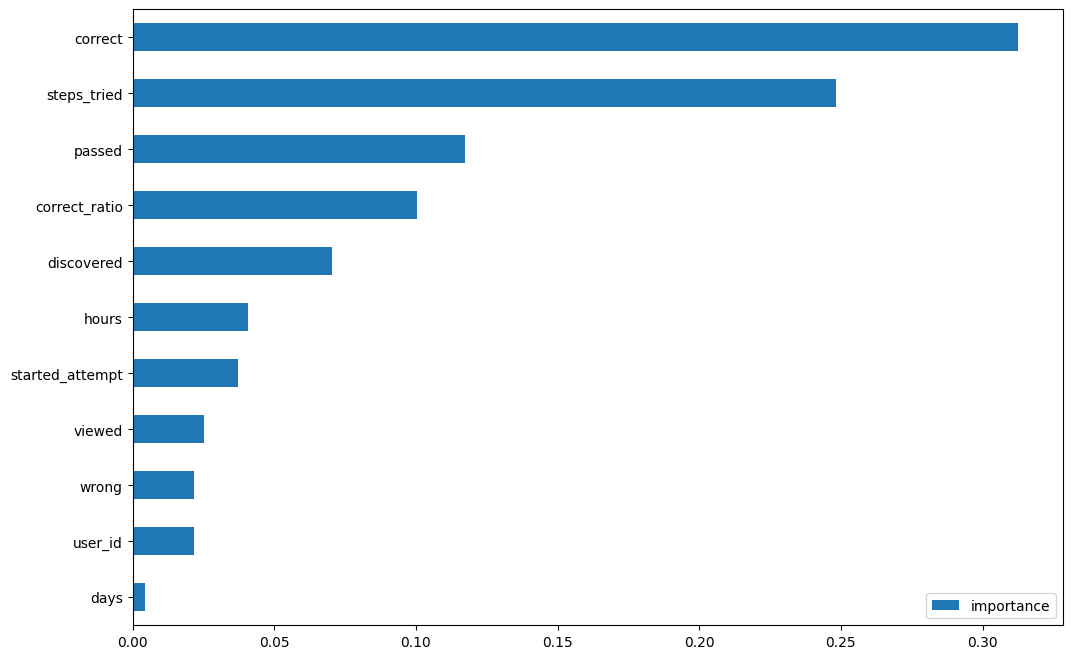

In [134]:
imp = pd.DataFrame(clf_rf.feature_importances_, index=X_train.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))
#Смотрим какие фичи являются важными

<h4>Я решил оставить все фичи.</h4>

In [137]:
cv_scores = cross_val_score(clf_rf, X_train, y_train, scoring='roc_auc', cv=10, n_jobs=-1)

In [140]:
cv_scores.mean() # roc auc который мы получили 

0.8900087209465501

<h2>Обучение</h2>

In [123]:
X_test = total_test

In [124]:
clf_rf = RandomForestClassifier(max_depth=6,
                                n_estimators=37)

In [125]:
clf_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, n_estimators=37)

In [141]:
prediction = clf_rf.predict_proba(X_test) # Предсказываем

In [142]:
total_df = total_test['user_id'].to_frame()

In [143]:
total_df['is_gone'] = prediction[:, 1]

In [144]:
total_df.to_csv('finish.csv', encoding='utf-8') #Импортируем в отдельный dataframe